# Import libraries

In [1]:
from kafka import KafkaConsumer
import pickle
import pandas as pd
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif,f_classif
from sklearn.metrics import f1_score


import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

# Load the Saved model

In [3]:
with open("../../pipeline_pickle",'rb') as file:
    Saved_model_static=pickle.load(file)
with open("../../pipeline_pickle",'rb') as file:
    Saved_model_Dynamic=pickle.load(file)

In [4]:
Saved_model_static

Pipeline(steps=[('selected_features',
                 Index(['FQDN_count', 'subdomain_length', 'upper', 'numeric', 'special',
       'labels', 'longest_word', 'sld'],
      dtype='object')),
                ('Scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

In [5]:
selected_features = Saved_model_static.named_steps['selected_features']
scaler = Saved_model_static.named_steps['Scaler']

static_model =Saved_model_static.named_steps['classifier']

Dynamic_Model=Saved_model_Dynamic.named_steps['classifier']

In [6]:
scaler

StandardScaler()

In [7]:
selected_features

Index(['FQDN_count', 'subdomain_length', 'upper', 'numeric', 'special',
       'labels', 'longest_word', 'sld'],
      dtype='object')

In [8]:
static_model

LogisticRegression(C=0.001, max_iter=1000, penalty='l1', solver='liblinear')

# Get_1000_rows to Create the necessary code to append 1,000 observations of data streaming

In [9]:
def Get_1000_rows():
    list_of_rows_1000=[]
    count=0
    for c in consumer:
        if count <1000:
            list_of_rows_1000.append(c.value)
            count=count+1
        else:
            break
    return list_of_rows_1000

In [10]:
Dynamic_Model

LogisticRegression(C=0.001, max_iter=1000, penalty='l1', solver='liblinear')

# convert_data_to_dataframe function to convert the binary data into Dataframe

In [11]:
columns_names =["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels",
            "labels_max","labels_average","longest_word","sld","len","subdomain","Target Attack"]

def convert_data_to_dataframe(data_list):
    if(eval(data_list[0].decode('utf-8')).strip().split(',')[1]=="FQDN_count"):
        data_list.pop(0)
    df_data = [eval(row.decode('utf-8')).strip().split(',') for row in data_list]
    df = pd.DataFrame(df_data, columns=columns_names)
    return df

# Preprocessing_Data function to do the same Preprocessing which made on the static part

In [12]:
def Preprocessing_data(Stream_data):
    Stream_data.dropna( inplace=True)
    target_longest_word_encoder = TargetEncoder()
    Stream_data['longest_word'] = target_longest_word_encoder.fit_transform(Stream_data[['longest_word']], Stream_data['Target Attack'])
    target_sld_encoder = TargetEncoder()
    Stream_data['sld'] = target_sld_encoder.fit_transform(Stream_data[['sld']], Stream_data['Target Attack'])
    Stream_data['Target Attack'] = Stream_data['Target Attack'].astype(int)
    dataset_clean=Stream_data.drop(["timestamp"],axis=1)
    return dataset_clean


# retrain_the_model use to retrain the Dynamic Model with new data

In [13]:
def retrain_the_model(x,y,model):
    new_model=model.fit(x,y,)
    return new_model

# load the Static_dataset to path sample of it to the training data for the Dynamic Model

In [14]:
static_dataset=pd.read_csv("Static_dataset.csv")

# Get 50000 sample from the Static dataset

In [15]:
sample_size = 50000
stratified_sample, _ = train_test_split(static_dataset, test_size=(len(static_dataset) - sample_size) / len(static_dataset), stratify=static_dataset["Target Attack"], random_state=42)


In [16]:
stratified_sample

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
73013,11:54.6,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,0
103235,08:46.8,17,3,0,15,0,2.530423,2,3,9,5.000000,skeet,teamskeet,13,1,0
70109,15:08.4,15,8,0,12,0,2.889975,3,4,4,3.000000,gov,gov,12,1,0
208803,04:21.6,14,0,0,13,0,2.530857,1,2,10,6.500000,tutors,tutorstips,11,0,0
1119,53:05.2,11,0,0,10,0,2.817711,1,2,8,5.000000,life,manulife,9,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129995,25:23.8,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,0
51520,59:41.7,10,0,0,9,0,2.375000,1,2,7,4.500000,life,viplife,8,0,0
194751,03:51.4,10,0,0,8,0,2.625000,2,2,7,4.500000,sma,sma-ren,8,0,0
246010,46:02.6,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1


# Drop duplicated

In [17]:

stratified_sample.duplicated().sum()

4434

In [18]:
static_dataset.drop_duplicates(inplace=True)


# Evaluation_Static_Dynamic 
* this is built in function use to Evaluate the dynamic model’s performance and create a decision boundary to
retrain the model or keep it as is.
* Evaluate the performance of each model on each window

In [19]:
def Evaluation_Static_Dynamic(K,stratified_sample,static_model,Dynamic_Model):
    list_of_f1_Dynmaic_model=[]
    list_of_f1_static_model=[]

    training_data=Preprocessing_data(stratified_sample)

    X_old_data =training_data.drop(labels = ["Target Attack"], axis=1)
    y_old_data=training_data["Target Attack"]

    X_selected_Feature_old_data=X_old_data[selected_features]

    X_scaled__old_data=scaler.transform(X_selected_Feature_old_data)
    Dynamic_data = pd.DataFrame(X_scaled__old_data, columns=X_selected_Feature_old_data.columns)



    for batch in range(0,K):
        print (f"window {batch+1}")
        r_dataset = Get_1000_rows()
        p_dataset =  convert_data_to_dataframe(r_dataset)
        new_dataset =  Preprocessing_data(p_dataset)

        X =new_dataset.drop(labels = ["Target Attack"], axis=1)
        y=new_dataset["Target Attack"]
        
        X_selected_Feature=X[selected_features]
        X_scaled=scaler.transform(X_selected_Feature)
        
        # training_data=X_selected_Feature

        # static_model
        y_pred_static=static_model.predict(X_scaled)
        f1_score_static=f1_score(y,y_pred_static)
        print(f"The F1_Score of Static Model = {f1_score_static*100}%")


        #  Dynamic_Model
        y_pred_Dynamic=Dynamic_Model.predict(X_scaled)
        f1_Score_Dynamic=f1_score(y,y_pred_Dynamic)
        print(f"The F1-Score of Dynamic Model without retrain = {f1_Score_Dynamic*100}%")
        
        X_scaled_df = pd.DataFrame(X_scaled, columns=X_selected_Feature.columns)

        Dynamic_data=pd.concat([Dynamic_data,X_scaled_df])
        y_old_data=pd.concat([y_old_data,y])

        if f1_Score_Dynamic < 0.85 :
            print(" trained model on the new data")

            


            Dynamic_Model=retrain_the_model(Dynamic_data.values,y_old_data.values,Dynamic_Model)
            
            Y_retrain_Dynamic=Dynamic_Model.predict(X_scaled)# test logic
            f1_Score_Dynamic=f1_score(y,Y_retrain_Dynamic)
            print(f"The f1 of Dynamic Model after retrain = {f1_Score_Dynamic*100}%")


        list_of_f1_Dynmaic_model.append(f1_Score_Dynamic)
        list_of_f1_static_model.append(f1_score_static)
        
    return list_of_f1_Dynmaic_model,list_of_f1_static_model



# Run Evaluation_Static_Dynamic And path to it static_model and Dynamic_Model

In [20]:
list_of_f1_Dynmaic_model,list_of_f1_static_model=Evaluation_Static_Dynamic(260,stratified_sample,static_model,Dynamic_Model)

window 1
The F1_Score of Static Model = 83.97070789259561%
The F1-Score of Dynamic Model without retrain = 83.97070789259561%
 trained model on the new data
The f1 of Dynamic Model after retrain = 84.22764227642277%
window 2
The F1_Score of Static Model = 84.80509148766906%
The F1-Score of Dynamic Model without retrain = 84.71337579617835%
 trained model on the new data
The f1 of Dynamic Model after retrain = 84.68899521531101%
window 3
The F1_Score of Static Model = 83.64485981308411%
The F1-Score of Dynamic Model without retrain = 83.75%
 trained model on the new data
The f1 of Dynamic Model after retrain = 83.69905956112854%
window 4
The F1_Score of Static Model = 85.55984555984554%
The F1-Score of Dynamic Model without retrain = 84.62138953942232%
 trained model on the new data
The f1 of Dynamic Model after retrain = 84.62138953942232%
window 5
The F1_Score of Static Model = 84.0064620355412%
The F1-Score of Dynamic Model without retrain = 83.73983739837398%
 trained model on the n

# Plot the results obtained for both models

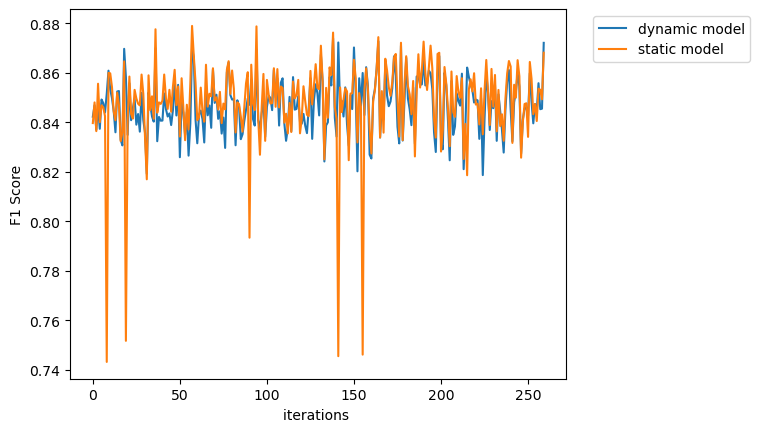

In [21]:
import matplotlib.pyplot as plt
plt.plot(range(0, 260), list_of_f1_Dynmaic_model, label=f'dynamic model')
plt.plot(range(0, 260),list_of_f1_static_model, label=f'static model')
plt.xlabel('iterations ')
plt.ylabel("F1 Score")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")